In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd

Дерево решений — еще одна модель машинного обучения. Структура дерева представляет собой «листья» и «ветки». На рёбрах («ветках») дерева решения записаны атрибуты, от которых зависит целевая функция, в «листьях» записаны значения целевой функции, а в остальных узлах — атрибуты, по которым различаются случаи. Чтобы классифицировать новый случай, надо спуститься по дереву до листа и выдать соответствующее значение. 

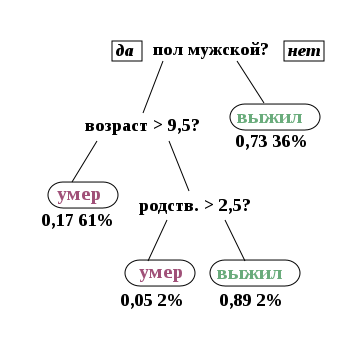

## Алгоритм ID3

Принцип работы:
1. Взять все неиспользованные признаки и посчитать их энтропию относительно тестовых образцов
2. Выбрать признак, для которого энтропия минимальна (а информационная выгода соответственно максимальна)
3. Сделать узел дерева, содержащий этот признак

Алгоритм следующий:
1. Если все примеры положительны, то возвратить узел с меткой «+».
2. Если все примеры отрицательны, то возвратить узел с меткой «-».
3. Если множество признаков пустое, то возвратить узел с меткой, которая больше других встречается в значениях целевого признака в примерах.
4. Иначе:
1) A — признак, который лучше всего классифицирует примеры (с максимальной )информационной выгодой).
2) Создать корень дерева решения; признаком в корне будет являться A.
3) Для каждого возможного значения A(v_i):
4) Добавить новую ветвь дерева ниже корня с узлом со значением A=v_i
5) Выделить подмножество Examples(v_i) примеров, у которых  A=v_i.
6) Если подмножество примеров пусто, то ниже этой новой ветви добавить узел с меткой, которая больше других встречается в значениях целевого признака в примерах.
7) Иначе, ниже этой новой ветви добавить поддерево, вызывая рекурсивно ID3(Examples(v_i), Целевой признак, Признаки)
5. Возвратить корень.

Энтропия:

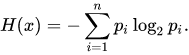

Критерий Джини:

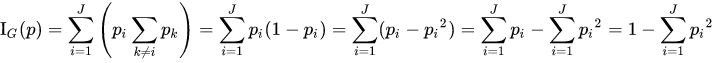

Variance:

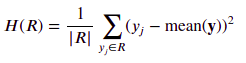

Mad_median:

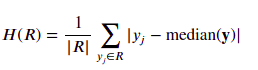

In [34]:
import numpy as np
from sklearn.base import BaseEstimator

def is_one_class(y):
    if len(np.unique(y)) == 1:
        return True
    else:
        return False
    
def class_leaf(y_subset):
    uniq_classes, uniq_classes_counts = np.unique(y_subset, return_counts=True)
    idx = np.argmax(uniq_classes_counts)
    return uniq_classes[idx]

def get_overall_entropy(left_branch, right_branch):
    
    n_all = len(left_branch) + len(right_branch)
    n_left = len(left_branch) / n_all
    n_right = len(right_branch) / n_all
    
    overall_entropy = (n_left * entropy(left_branch) + n_right * entropy(right_branch))
    
    return overall_entropy

def entropy(y):  
    # EPS - for numerical stability
    EPS = 0.0005
    _, uniq_classes_counts = np.unique(y, return_counts=True)
    rate = uniq_classes_counts / uniq_classes_counts.sum()
    
    entropy = - sum(rate * np.log2(rate + EPS))
    
    return entropy
    
def gini(y):
    _, uniq_classes_counts = np.unique(y, return_counts=True)
    rate = uniq_classes_counts / uniq_classes_counts.sum()
    gini = 1 - sum(rate ** 2)
    
    return gini
    
def variance(y):
    
    variance = sum((y[0] - y[0].mean())**2) / len(y)
    
    return variance

def mad_median(y):

    mad_median = sum(np.abs(y[0] - y[0].median())) / len(y)
    
    return mad_median


def one_hot_encode(n_classes, y):
    y_one_hot = np.zeros((len(y), n_classes), dtype=float)
    y_one_hot[np.arange(len(y)), y.astype(int)[:, 0]] = 1.
    return y_one_hot


def one_hot_decode(y_one_hot):
    return y_one_hot.argmax(axis=1)[:, None]


class Node:
    def __init__(self, feature_index, threshold,mean_value=None, proba=0):
        self.feature_index = feature_index
        self.value = threshold
        self.proba = proba
        self.left_child = None
        self.right_child = None
        self.mean_value = mean_value
        
        
class DecisionTree(BaseEstimator):
    all_criterions = {
        'gini': (gini, True), # (criterion, classification flag)
        'entropy': (entropy, True),
        'variance': (variance, False),
        'mad_median': (mad_median, False)
    }

    def __init__(self, n_classes=None, max_depth=np.inf, min_samples_split=2, 
                 criterion_name='gini', debug=False):

        assert criterion_name in self.all_criterions.keys(), 'Criterion name must be on of the following: {}'.format(self.all_criterions.keys())
        
        self.n_classes = n_classes
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion_name = criterion_name

        self.depth = 0
        self.root = None # Use the Node class to initialize it later
        self.debug = debug

        
        
    def make_split(self, feature_index, threshold, X_subset, y_subset):
        X_left = X_subset[X_subset[:, feature_index] < threshold]
        y_left = y_subset[X_subset[:, feature_index] < threshold]
        
        X_right = X_subset[X_subset[:, feature_index] >= threshold]
        y_right = y_subset[X_subset[:, feature_index] >= threshold]
        
        
        return (X_left, y_left), (X_right, y_right)
    
    def make_split_only_y(self, feature_index, threshold, X_subset, y_subset):
        y_left = y_subset[X_subset[:, feature_index] < threshold]
        y_right = y_subset[X_subset[:, feature_index] >= threshold]
        
        return y_left, y_right
    
    def get_thresholds(self, X_subset, y_subset):
        thresholds = {}

        n_features = X_subset.shape[1]

        for n_feature in range(n_features - 1):
            thresholds[n_feature] = []
            unique_values = np.unique(X_subset[:, n_feature])
            
            for idx in range(len(unique_values)):
                if idx:
                    cur_value = unique_values[idx]
                    prev_value = unique_values[idx - 1]
                    possible_split = (cur_value + prev_value) / 2
                    thresholds[n_feature].append(possible_split)
                    
        return thresholds

    def choose_best_split(self, X_subset, y_subset):
        thresholds = self.get_thresholds(X_subset, y_subset)
                    
        overall_entropy = np.inf

        for col in thresholds:
            # для ускорения
            # if len(thresholds[col]) > 3:
            #     rand_thresholds = np.random.choice(thresholds[col], size=3)
            # else:
            rand_thresholds = thresholds[col]
            for thresh in rand_thresholds:
                (X_left, y_left), (X_right, y_right) = self.make_split(col, thresh, X_subset, y_subset)
                left_branch = np.hstack([X_left, y_left])
                right_branch = np.hstack([X_right, y_right])
                
                i_entropy = get_overall_entropy(left_branch, right_branch)
                if i_entropy <= overall_entropy:
                    overall_entropy = i_entropy
                    optimal_col = col
                    optimal_thresh = thresh
        
        threshold = optimal_thresh
        feature_index = optimal_col
        
        return feature_index, threshold
    
    def tree(self, X_subset, y_subset, counter=0, node=None):
        if is_one_class(y_subset) or len(y_subset) < self.min_samples_split or counter > self.max_depth:
            return class_leaf(y_subset)
        else:
            counter += 1
            
        thresholds = self.get_thresholds(X_subset, y_subset)

        is_thresholds = 0
        for i in thresholds:
            is_thresholds += len(thresholds[i])
        if not is_thresholds:
            return class_leaf(y_subset)

        
        optimal_column, optimal_threshold = self.choose_best_split(X_subset, y_subset)
        (X_left, y_left), (X_right, y_right) = self.make_split(optimal_column, optimal_threshold, X_subset, y_subset)

        to_left = self.tree(X_left, y_left, counter)
        to_right = self.tree(X_right, y_right, counter)
        
        node = Node(feature_index=optimal_column, threshold=optimal_threshold, mean_value=np.mean(y_subset, axis=0))
        if counter == 1:
            self.root = node
        node.left_child = to_left
        node.right_child = to_right
        return node
        
    
    def make_tree(self, X_subset, y_subset):
        root_node = self.tree(X_subset, y_subset)
        
        return root_node
        
    def fit(self, X, y):
        assert len(y.shape) == 2 and len(y) == len(X), 'Wrong y shape'
        self.criterion, self.classification = self.all_criterions[self.criterion_name]
        if self.classification:
            if self.n_classes is None:
                self.n_classes = len(np.unique(y))
            y = one_hot_encode(self.n_classes, y)

        self.root = self.make_tree(X, y)
        

    def _predict(self, inputs):
        node = self.root
        while node.left_child:
            if inputs[node.feature_index] < node.value:
                node = node.left_child
            else:
                node = node.right_child
            if type(node) == np.float64:
                return node
            elif node.mean_value is None:
                return node
        return np.argmax(node.mean_value)
    
    def _predict_proba(self, inputs):
        node = self.root
        while node.left_child:
            if inputs[node.feature_index] < node.value:
                node = node.left_child
            else:
                node = node.right_child
            if type(node) == np.float64:
                return node
            elif node.mean_value is None:
                return node
        return node.mean_value
    
    def predict(self, X):
        return np.asarray([self._predict(inputs) for inputs in X])

        
    def predict_proba(self, X):
        assert self.classification, 'Available only for classification problem'
        return np.asarray([self._predict_proba(inputs) for inputs in X])

In [26]:
digits_data = load_digits().data
digits_target = load_digits().target[:, None] 
X_train, X_test, y_train, y_test = train_test_split(digits_data, digits_target, test_size=0.2)

In [35]:
%%time
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_gini = accuracy_score(y_test, ans)
print(accuracy_gini)

0.4388888888888889
CPU times: user 34.8 s, sys: 80.8 ms, total: 34.9 s
Wall time: 34.9 s


In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=10, criterion='gini')
model.fit(X_train, y_train)
ans = model.predict(X_test)
accuracy_gini = accuracy_score(y_test, ans)
print(accuracy_gini)

0.8444444444444444


In [ ]:
%%time
class_estimator = DecisionTree(max_depth=10, criterion_name='entropy')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_entropy = accuracy_score(y_test, ans)
print(accuracy_entropy)

0.5472222222222223
CPU times: user 34 s, sys: 84.6 ms, total: 34.1 s
Wall time: 34.1 s


In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=10, criterion='entropy')
model.fit(X_train, y_train)
ans = model.predict(X_test)
accuracy_gini = accuracy_score(y_test, ans)
print(accuracy_gini)

0.8416666666666667


In [ ]:
regr_data = load_boston().data
regr_target = load_boston().target[:, None]
RX_train, RX_test, Ry_train, Ry_test = train_test_split(regr_data, regr_target, test_size=0.2)

In [ ]:
%%time
regressor = DecisionTree(max_depth=10, criterion_name='variance')
regressor.fit(RX_train, Ry_train)
predictions = regressor.predict(RX_test)
mse = mean_squared_error(Ry_test, predictions)
print(mse)

50.29852941176472
CPU times: user 5.38 s, sys: 999 µs, total: 5.38 s
Wall time: 5.39 s


In [ ]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=10, criterion='mse')
model.fit(RX_train, Ry_train)
predictions = model.predict(RX_test)
mse = mean_squared_error(Ry_test, predictions)
print(mse)

14.648915526664874


Домашнее задание. Реализовать критерии friedman_mse и poisson https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html.

Найти наилучшие параментры с помощью GridSearchCV.